<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  901 non-null    datetime64[ns]
 1   ONI                   901 non-null    float64       
 2   ENSO Phase-Intensity  901 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 21.2+ KB


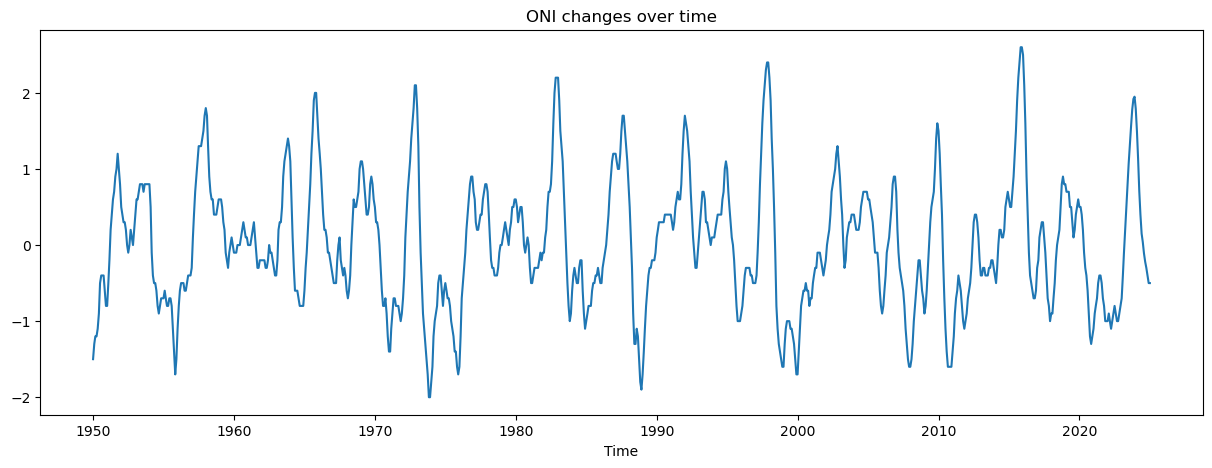

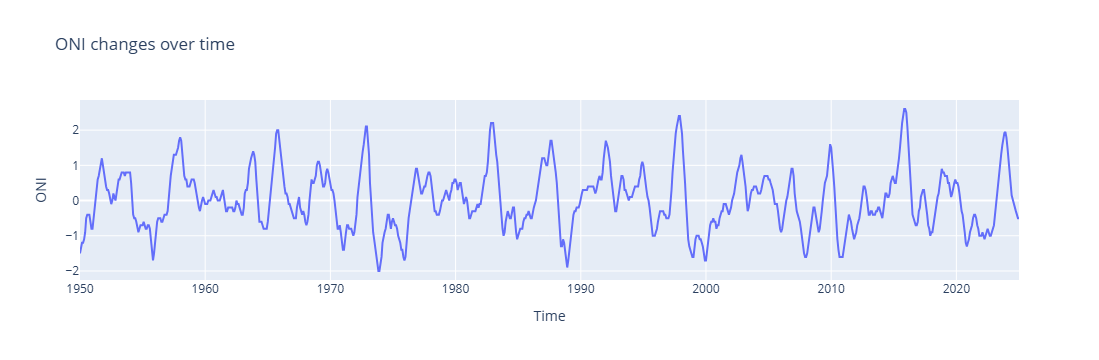

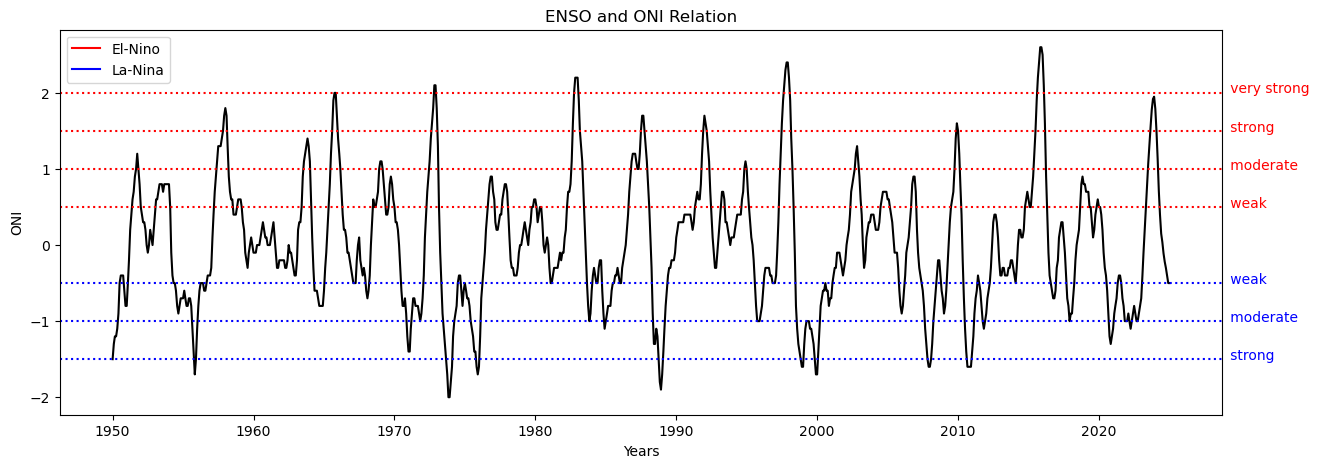

Loaded existing model
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0043 - mae: 0.0506 - mape: 13.6416 - root_mean_squared_error: 0.0656 
Model evaluation: {'loss': 0.004240935668349266, 'mae': 0.050209518522024155, 'mape': 13.597375869750977, 'root_mean_squared_error': 0.06512247025966644}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


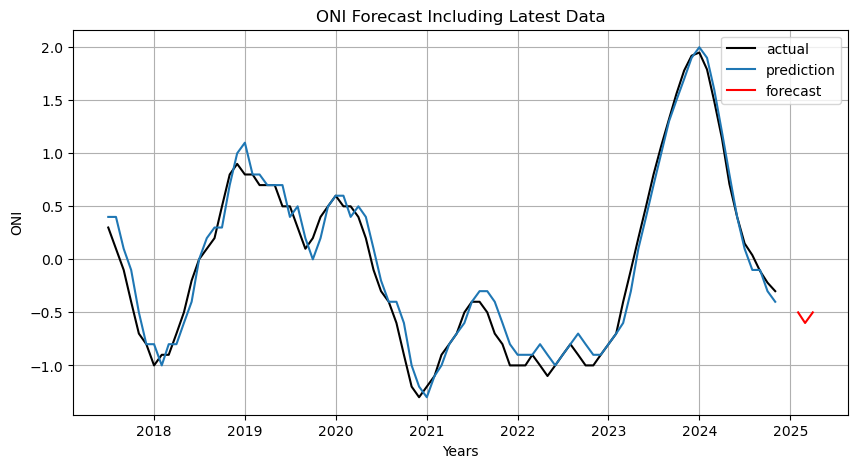

Forecast for the next 3 months:
2025-02: -0.5
2025-03: -0.6
2025-04: -0.5


In [4]:
import matplotlib
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import plotly.express as px 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, TimeDistributed
from tensorflow.keras.metrics import RootMeanSquaredError

# Load the dataset (this will include any newly added values)
df_enso = pd.read_csv(r"C:\Users\bhanu\OneDrive\Desktop\project\ENSO EVENTS PREDICTION\ENSO.csv", parse_dates=[0])
df_enso.head()

# data information (columns, rows, data tyype, null values etc) 
df_enso.info()

# statistics summary
df_enso.describe()

# missing values
df_enso.isna().sum(axis=0)

# set index
df_enso.set_index('Date', inplace = True)
df_enso.head(5)

# ONI time series
plt.figure(figsize=(15,5))
plt.plot(df_enso.ONI)
plt.title('ONI changes over time')
plt.xlabel('Time')
plt.show()

# ONI interactive time series
plot = px.line(data_frame=df_enso, y='ONI', labels={'Date':'Time'},
               title='ONI changes over time')
plot.show()

# ONI and ENSO relation

plt.figure(figsize=(15, 5))

# convert dates to numbers to get x-axis range
x = matplotlib.dates.date2num(df_enso.index)

# plot Year and ONI
plt.plot(df_enso.ONI, color='black')
plt.xlabel('Years')
plt.ylabel('ONI')
plt.title('ENSO and ONI Relation')

# add horizontal lines and labels to define ENSO phase and intensity

plt.axhline(y=2, color='r', linestyle=':')
plt.text(x=x[-1], y=2, color='red', s='              very strong')

plt.axhline(y=1.5, color='r', linestyle=':')
plt.text(x=x[-1], y=1.5, color='red', s='              strong')

plt.axhline(y=1, color='r', linestyle=':')
plt.text(x[-1], 1, color='r', s='              moderate')

plt.axhline(y=0.5, color='r', linestyle=':')
plt.text(x[-1], 0.5, color='r', s='              weak')

plt.axhline(y=-0.5, color='b', linestyle=':')
plt.text(x[-1], -0.5, color='b', s='              weak')

plt.axhline(y=-1, color='b', linestyle=':')
plt.text(x[-1], -1, color='b', s='              moderate')

plt.axhline(y=-1.5, color='b', linestyle=':')
plt.text(x[-1], -1.5, color='b', s='              strong')

# custom legends
line_red = matplotlib.lines.Line2D([0], [0], label='El-Nino', color='r')
line_blue = matplotlib.lines.Line2D([0], [0], label='La-Nina', color='b')
plt.legend(handles=[line_red, line_blue])

plt.show()

# missing values in ONI
df_enso.ONI.isna().sum(axis=0)

# function to transform time series data into supervised learning data
def series_to_supervised(data, n_in=1, n_out=1, n_vars=1, forecast_all=True, 
                         dropnan=True):
    """
    Frame a time series as a supervised learning dataset
    Parameters:
        data: Sequence of observations, type = dataframe
        n_in: prior timesteps or Number of lag observations as input (x)
        n_out: next timesteps or Number of ahead observations as output (y)
        n_vars: number of variables or number of columns
        forecast_all: to forecast all or one variable
        dropnan: Boolean whether or not to drop rows with NaN values
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    
    cols, names = list(), list()
    
    if n_vars == 1:    # univariate
        # input sequence or previous timesteps (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(data.shift(i))
            names.append(f'var1 (t-{i})')
        # current time steps (t)
        cols.append(data)
        names.append('var1 (t)')
        # forecast sequence or next timesteps (t+1, ... t+n)
        for i in range(1, n_out):
            cols.append(data.shift(-i))
            names.append(f'var1 (t+{i})')
    elif forecast_all:    # mutlivariate type 1
        for i in range(n_in, 0, -1):
            cols.append(data.shift(i))
            names += [f'var{j+1} (t-{i})' for j in range(n_vars)]
        cols.append(data)
        names += [f'var{j+1} (t)' for j in range(n_vars)]
        for i in range(1, n_out):
            cols.append(data.shift(-i))
            names += [f'var{j+1} (t+{i})'for j in range(n_vars)]
    else:    # multivariate type 2
        for i in range(n_in, 0, -1):
            cols.append(data.shift(i))
            names += [f'var{j+1} (t-{i})' for j in range(n_vars)]
        cols.append(data.iloc[:, -1])
        names.append('VAR (t)')
        for i in range(1, n_out):
            cols.append(data.shift(-i).iloc[:,-1])
            names.append(f'VAR (t+{i})')
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# specify the size of the sliding window (n_lag, n_ahead)
n_in = 12
n_out = 3

# timesteps & features
n_steps = n_in                  
n_features = 1   # we are using only one feature/variable i.e oni 

# transform data to get input (x) and output (y) 
df_reframed = series_to_supervised(df_enso['ONI'], n_in, n_out, n_features)
df_reframed

# train-validation-test split (80:10:10)
n = df_reframed.shape[0]       
n_train, n_valid = int(0.8 * n), int(0.1 * n)
df_train = df_reframed.values[:n_train, :]
df_valid = df_reframed.values[n_train:n_train + n_valid, :]
df_test = df_reframed.values[n_train + n_valid:, :]

x_train, y_train = df_train[:, :-n_out], df_train[:, -n_out:]
x_valid, y_valid = df_valid[:, :-n_out], df_valid[:, -n_out:]
x_test, y_test = df_test[:, :-n_out], df_test[:, -n_out:]

# normalize data
x_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

x_train_scaled = x_scaler.fit_transform(x_train)
y_train_scaled = y_scaler.fit_transform(y_train)
x_valid_scaled = x_scaler.transform(x_valid)
y_valid_scaled = y_scaler.transform(y_valid)
x_test_scaled = x_scaler.transform(x_test)
y_test_scaled = y_scaler.transform(y_test)

# reshape input [samples (rows), timesteps, features]
x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], n_steps, n_features)
x_valid_reshaped = x_valid_scaled.reshape(x_valid_scaled.shape[0], n_steps, n_features)
x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], n_steps, n_features)

# Check if model exists, if not build and train it
try:
    model = load_model('model_lstm.keras')
    print("Loaded existing model")
except:
    print("Building and training new model")
    # design network
    model = Sequential(name='lstm')
    model.add(LSTM(50, input_shape=(n_steps, n_features), return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(n_out))
    model.summary()

    # compile & train network
    model.compile(loss='mean_squared_error', optimizer='adam',
                  metrics=['mae', 'mape', RootMeanSquaredError()])
    hist = model.fit(x_train_reshaped, y_train_scaled, 
                     validation_data=(x_valid_reshaped, y_valid_scaled),
                     shuffle=False, epochs=50, batch_size=32, verbose=2)
    
    # Save the model
    model.save('model_lstm.keras')
    
    # Plot training and validation loss
    plt.figure()
    plt.plot(hist.history['loss'], label='Training')
    plt.plot(hist.history['val_loss'], label='Validation')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

# evaluate model
eval_lstm = model.evaluate(x=x_test_reshaped, y=y_test_scaled, return_dict=True)
print("Model evaluation:", eval_lstm)

# predict for test data
y_hat = model.predict(x_test_reshaped)
y_hat = np.round(y_scaler.inverse_transform(y_hat), 1)

# Now for the latest data (including newly added values)
# Get the latest n_in values for prediction
latest_data = df_enso['ONI'].values[-n_in:]

# If we have enough data for prediction
if len(latest_data) >= n_in:
    # Prepare the latest data for prediction
    latest_data = latest_data.reshape(1, n_in)  # Reshape for scaling
    latest_data_scaled = x_scaler.transform(latest_data)  # Scale
    latest_data_reshaped = latest_data_scaled.reshape(1, n_steps, n_features)  # Reshape for LSTM
    
    # Predict using the latest data
    latest_prediction = model.predict(latest_data_reshaped)
    latest_prediction = np.round(y_scaler.inverse_transform(latest_prediction), 1)
    
    # Find y_test start row index
    y_start = n_train + n_valid + 1
    
    # Get actual and predicted data with adjusted lengths to avoid shape mismatch
    inverse_y_test = y_scaler.inverse_transform(y_test_scaled)[:, 0]
    available_indices = df_reframed.index[y_start:]
    
    # Adjust lengths to match - the key fix for the shape mismatch error
    min_length = min(len(available_indices), len(inverse_y_test))
    y_actual = pd.DataFrame(index=available_indices[:min_length],
                          data=inverse_y_test[:min_length])
    
    min_length_pred = min(len(available_indices), len(y_hat[:, 0]))
    y_predict = pd.DataFrame(index=available_indices[:min_length_pred],
                          data=y_hat[:, 0][:min_length_pred])
    
    # Create forecast dates (starting after the last date in df_enso)
    forecast_dates = pd.date_range(start=df_enso.index[-1] + pd.DateOffset(months=1), 
                                 periods=n_out, freq='MS')
    
    # ONI forecast values for the latest data
    y_forecast = pd.DataFrame(index=forecast_dates,
                           data=latest_prediction[0, :])
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(y_actual, label='actual', color='k')
    plt.plot(y_predict, label='prediction')
    plt.plot(y_forecast, label='forecast', color='r')
    plt.xlabel('Years')
    plt.ylabel('ONI')
    plt.legend()
    plt.grid()
    plt.title('ONI Forecast Including Latest Data')
    plt.show()
    
    # Print the forecast values
    print("Forecast for the next", n_out, "months:")
    for i, date in enumerate(forecast_dates):
        print(f"{date.strftime('%Y-%m')}: {latest_prediction[0, i]:.1f}")
else:
    print(f"Not enough data for prediction. Need {n_in} values but only have {len(latest_data)}.")